# MAD Mix GMM extension

To handle multivariate data and learn weights and covariance matrices.

## Model details

We will use conjugate priors to make all the calculations easier.
The discrete variables $x_{d,1:N}$ correspond to the cluster labels.
The full conditionals are proportional to the weighted Gaussian pdf:
$$
    \mathbb{P}(X_{d,n}=k \,|\,x_{d,-n},w_{1:K},\mu_{1:K},\Sigma_{1:K})
    \propto w_k\phi_{\mu_k,\Sigma_k}(y_n)
$$
for $n=1,\dots,N,\,k=1,\dots,K$.

The continuous variables are slightly trickier.
From the mean-field setting, we have that
$$
    w_{1:K}\sim\mathrm{Dirichlet}(N_1+1,\dots,N_K+1)
$$
where $N_k=\sum_n \mathbf{1}(x_n=k)$ is the number of elements in cluster $k$.

Within each cluster $k$, the mean and covariance follow a Gaussian-InverseWishart distribution:
$$
   \mu_k\,|\,\Sigma_k\sim\mathcal{N}(\bar{y}_k,\Sigma_k/N_k),\\
   \Sigma_k\sim\mathrm{IW}(S_k,N_k-D-1),
$$
where $\bar{y}_k=N_k^{-1}\sum_n y_n\mathbf{1}(x_n=k)$ is the mean of elements in cluster $k$
and $S_k=\sum_n (y_n-\bar{y}_k)(y_n-\bar{y}_k)^\top \mathbf{1}(x_n=k)$ the 
corresponding (scaled) covariance.

This results in a joint target (with fixed labels)
of the form $p(w,\mu,\Sigma)=p(w)\prod_k p(\mu_k\,|\,\Sigma_k)p(\Sigma_k)$.


## Implementation details

For the deterministic Hamiltonian move,
we need the score function of the parameters $(w,\mu,\Sigma)$.
Note that the score w.r.t. the weights will only depend on $p(w)$
and the score w.r.t. the $k$th mean will only depend on $p(\mu_k\,|\,\Sigma_k)$.

The score w.r.t. the weights is then
$$
    \nabla_w \log p(w,\mu,\Sigma)
    =\nabla_w \log p(w)
    =\nabla_w \sum_k N_k \log w_k
    =\left(\frac{N_1}{w_1},\dots,\frac{N_K}{w_K}\right)^\top.
$$

The score w.r.t. the means is 
$$
    \nabla_{\mu_k} \log p(w,\mu,\Sigma)
    =\nabla_{\mu_k} \log p(\mu_k\,|\,\Sigma)
    =\nabla_{\mu_k} -\frac{N_k}{2}(\mu_k-\bar{y}_k)\top\Sigma_k^{-1}(\mu_k-\bar{y}_k)
    =-N_k\Sigma_k^{-1}(\mu_k-\bar{y}_k).
$$

Finally, the score w.r.t. the covariances depends on both the mean pdf and the covariance pdf:
$$
    \nabla_{\Sigma_k} \log p(w,\mu,\Sigma)
    =\nabla_{\Sigma_k}\log p(\mu_k\,|\,\Sigma_k) + \log p(\Sigma_k).
$$
The first term is
$$
    \nabla_{\Sigma_k}\log p(\mu_k\,|\,\Sigma_k)
    =\nabla_{\Sigma_k} -\frac{1}{2}\log|\Sigma_k|
    -\frac{N_k}{2}(\mu_k-\bar{y}_k)\top\Sigma_k^{-1}(\mu_k-\bar{y}_k)
    =-\frac{1}{2}\Sigma_k^{-\top}-\frac{N_k}{2}(\mu_k-\bar{y}_k)(\mu_k-\bar{y}_k)^\top,
$$
where we used the identities $\partial \log|X|=X^{-\top}$
and $\partial a^\top X b=ab^\top$ from the 
[matrixcookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).

The second term is
$$
    \nabla_{\Sigma_k}\log p(\Sigma_k)
    =\nabla_{\Sigma_k} -\frac{N_k}{2}\log|\Sigma_k|-\frac{1}{2}\mathrm{tr}(S_k\Sigma_k^{-1})
    =-\frac{N_k}{2}\Sigma_k^{-\top}+\frac{1}{2}\left(\Sigma_k^{-1}S_k\Sigma_k^{-1}\right)^\top,
$$
where we used the 
[pdf of the Inverse-Wishart distribution](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution)
and the identity $\partial\mathrm{tr}(AX^{-1}B)=-X^{-\top}A^\top B^\top X^{-\top}$
from the [matrixcookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).

Adding together these two expressions yields the score w.r.t. covariance:
$$
    \nabla_{\Sigma_k} \log p(w,\mu,\Sigma)
    =-\frac{1}{2}(1+N_k)\Sigma_k^{-\top}
    -\frac{N_k}{2}(\mu_k-\bar{y}_k)(\mu_k-\bar{y}_k)^\top
    +\frac{1}{2}\left(\Sigma_k^{-1}S_k\Sigma_k^{-1}\right)^\top.
$$

## Covariance parametrization

In practice, we don't want to deal with the covariance directly since it contains too many restrictions:
it has to be symmetric and positive definite,
and taking Hamiltonian steps can easily make the resulting matrix inadmissible.
Instead, we follow
[the Stan documentation on covariances](https://mc-stan.org/docs/reference-manual/covariance-matrices-1.html).
Given a covariance matrix $\Sigma$,
let $\Sigma=LL^\top$ be its (unique) Cholesky decomposition.
The matrix $L$ is lower triangular and has positive diagonal elements.
Hence we only need to store the diagonal and lower diagonal elements&mdash;the rest are zero by default.
To further remove the positiveness condition,
define $H$ as a copy of $L$ but with the diagonal logged:
$$
    H_{ij}=\begin{cases}
        0,&i<j,\\
        \log L_{ij},&i=j,\\
        L_{ij},&i>j.
    \end{cases}
$$
By taking steps in $H$-space, one is always guaranteed to get back a valid covariance matrix.
To map from $H$ to $\Sigma$,
one simply exponentiates the diagonal to get $L$ and then sets $\Sigma=LL^\top$.

Let $f$ be the function that maps $\Sigma$ to $H$, so that $f(\Sigma)=H$.
The Jacobian of the transformation can be found in closed-form and
the resulting density is given by
$$
    \log p(H)=\log p(\Sigma)+\sum_{d=1}^D (D-d+2)H_{dd} +D\log2,
$$
where $D$ is the dimension of the space where the observations live, $y_n\in\mathbb{R}^D$.

## Score w.r.t. $H$
To take a Hamiltonian step in $H$ space, we need $\nabla_H \log p(H)$.
We can use the formula we derived above and take gradient w.r.t. $H$.
The third term does not depend on $H$.
The second term is
$$
\nabla_H \sum_{d=1}^D (D-d+2)H_{dd}
=\nabla_H \mathrm{Tr}(\mathrm{diag((D+1)H_{11},\dots,2H_{DD}})
=\nabla_H \mathrm{Tr}(H\mathrm{diag}((D-d+2)_{d=1}^D))
=(\mathrm{diag}((D-d+2)_{d=1}^D))^\top,
$$
i.e., a diagonal matrix with the $d$th diagonal entry equal to $D-d+2$.
Here we used the identity $\partial\mathrm{Tr}(XA)=A^\top$
from page 12 of the [matrixcookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).

Using the chain rule, the first term can be diff'd via
$$
    \nabla_H \log p_\Sigma(f^{-1}(H))
    = \nabla_H f^{-1}(H)\nabla_\Sigma \log p_\Sigma(f^{-1}(H)).
$$
The second factor is equal to $\nabla_\Sigma \log p_\Sigma(\Sigma)$
since $\Sigma=f(H)$,
and we derived that gradient above.

The first factor is the Jacobian of the inverse transform $f$.
Note that this is a $D^2\times D^2$ matrix,
so the second factor should be understood as a $D^2$ vector (a flattened matrix).
We find this matrix by computing the Jacobian matrix of the transform
from $H$ to $L$, say $J_1$,
and multiplying it with the corresponding Jacobian
of the map from $L$ to $LL^\top=\Sigma$, $J_2$.
The first Jacobian matrix $J_1$ is diagonal with entries
either 1 or $\exp(H_{dd})$. Specifically,
$$
    J_1=\mathrm{Diag}(\exp(H_{11}),1,\exp(H_{22}),1,\dots,\exp(H_{DD}),1).
$$
This is because 
$$
    \frac{\partial L_{ij}}{\partial H_{lk}}=
    \begin{cases}
    \exp{H_{lk}},& i=l=j=k,\\
    1,&  i=l\neq j=k,\\
    0,&\mathrm{o.w.}
    \end{cases}
$$
For $J_2$, we introduce the $D^2\times D^2$ commutation matrix $K_D$.
If $A$ is a $DxD$ matrix denote by $\mathrm{vec}(A)$ the vectorized or flattened
version of $A$, i.e., the $D^2$ vector obtained by stacking the columns of $A$
one after the other.
Then $K_D$ satisfies that $K_D\mathrm{vec}(A)=\mathrm{vec}(A^\top)$.
As shown in [here](https://math.stackexchange.com/questions/2158399/derivative-of-symmetric-positive-definite-matrix-w-r-t-to-its-lower-triangular),
$$
    J_2=\frac{\partial\mathrm{vec}(LL^\top)}{\partial\mathrm{vec}(L)}
    =(L\otimes I_D)+(L\otimes I_D)K_D,
$$
where $\otimes$ is the [Kroenecker product](https://en.wikipedia.org/wiki/Kronecker_product)
and $I_D$ is the $D\times D$ identity matrix.
The tl;dr of the proof is decomposing
$\partial(LL^\top)=\partial L \,L^\top + L \partial L^\top$
and then using properties of vectorization and Kroenecker products.
Finally,
$$
    \nabla_H f^{-1}(H)=J_2 J_1.
$$

Note: the MSc thesis "On Jacobians connected with matrix variate random variables"
by Moses M. Njoroge (1988) contains a derivation of most of that $D^2\times D^2$
matrix in Figure 5 in the Appendix (page 84).
Download [here](https://escholarship.mcgill.ca/downloads/0p096811t).
The determinant Jacobian from above is also shown in page 39 (Theorem 4.2). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys,time
sys.path.insert(1, '../src/')
import madmix
import aux

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})

In [2]:
####################
####################
#   auxiliary fns  #
####################
####################
def madmix_gmm_flatten(ws,mus,Hs):
    """
    Flatten weights, meand, and logCholeskys into 2D array
    
    Inputs:
        ws  : (K,B) array, weights
        mus : (K,D,B) array, cluster means
        Hs  : (K,D,D,B) array, cluster logCholesky matrices
    
    Outpus:
        xc  : (K',B) array, flattened values
        
    Note:
    K is the number of clusters, D is data dimension, 
    and B is the number of data points (for vectorizing)
    K'= K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)
    """
    K,D,B=mus.shape
    
    flat_mus=mus.reshape(K*D,B)
    idx=np.tril_indices(D)
    flat_Hs=Hs[:,idx[0],idx[1],:]                     # recover lower triangular entries
    flat_Hs=flat_Hs.reshape(int(K*D*(1+0.5*(D-1))),B) # correct shape
    return np.vstack((ws,flat_mus,flat_Hs))


def madmix_gmm_unflatten(xc,K,D):
    """
    Unflatten xc into weights, meand, and covariances
    
    Inputs:
        xc  : (K',B) array, flattened values
    
    Outputs:
        ws  : (K,B) array, weights
        mus : (K,D,B) array, cluster means
        Hs  : (K,D,D,B) array, cluster logCholesky matrices
        
    Note:
    K is the number of clusters, D is data dimension, 
    and B is the number of data points (for vectorizing)
    K'= K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)
    """
    B=xc.shape[-1]
    
    # recover each flattened var
    ws=xc[:K,:]
    flat_mus=xc[K:(K*D+K),:]
    flat_Hs=xc[(K*D+K):,:].reshape(K,int(D*(1+0.5*(D-1))),B)
    
    # unflatten separately
    mus=flat_mus.reshape(K,D,B)
    Hs=np.zeros((K,D,D,B))
    idx=np.tril_indices(D)
    Hs[:,idx[0],idx[1],:]=flat_Hs
    
    return ws,mus,Hs


def HtoSigma(Hs):
    """
    Transform logCholesky factors into covariance matrices
    
    Inputs:
        Hs : (K,D,D,B) array, B observations of the K cluster logCholesky factors
        
    Outpus:
        Sigmas : (K,D,D,B) array, B observations of the K cluster covariances
    """
    
    idx=np.diag_indices(Hs.shape[1])
    Ls=np.copy(Hs)
    Ls[:,idx[0],idx[1],:]=np.exp(Hs[:,idx[0],idx[1],:])
    Ls=np.moveaxis(Ls,3,1) # so matrices are stacked in last two axes for matmul
    Sigmas=np.matmul(Ls,np.transpose(Ls,axes=(0,1,3,2)))
    return np.moveaxis(Sigmas,1,3)

def SigmatoH(Sigmas):
    """
    Transform covariance matrices into logCholesky factors
    
    Inputs:
        Sigmas : (K,D,D,B) array, B observations of the K cluster covariances
        
    Outpus:
        Hs : (K,D,D,B) array, B observations of the K cluster logCholesky factors
    """
    
    idx=np.diag_indices(Sigmas.shape[1])
    Ls=np.linalg.cholesky(np.moveaxis(Sigmas,3,1))
    Hs=np.copy(Ls)
    Hs[:,:,idx[0],idx[1]]=np.log(Ls[:,:,idx[0],idx[1]])
    return np.moveaxis(Hs,1,3)


#####################
# vec/vech matrices #
#####################

# elimination matrix (4,3)
L2=np.zeros((3,4))
L2[0,0],L2[1,1],L2[2,3]=1.,1.,1.

# duplication matrix (3,4)
D2=np.zeros((4,3))
D2[0,0],D2[1,1],D2[2,1],D2[2,2]=1.,1.,1.,1.

# commutation matrix (4,4)
K2=np.zeros((4,4))
K2[0,0],K2[1,2],K2[2,1],K2[3,3]=1.,1.,1.,1.

def HtoSigmaJacobian(Hs):
    """
    Calculate the Jacobian of the transformation H->Sigma
    Since the transformation is DxD->DxD,
    the Jacobian is a D**2xD**2 matrix 
    (to be multiplied with a vectorized matrix vec(grad log p(Sigma)))
    
    Note: ONLY WORKS WHEN D=2
    
    Inputs:
        Hs       : (K,D,D,B) array, cluster logCholesky matrices
        
    Outputs:
        jacobian : (K,D**2,D**2,B) array, Jacobian matrices
    """
    K,D,B=Hs.shape[0],Hs.shape[1],Hs.shape[3]
    jacobian=np.zeros((K,D**2,D**2,B))
    
    for k in range(K):
        for b in range(B):
            H=Hs[k,:,:,b]
            L=np.copy(H)
            L[0,0],L[1,1]=np.exp(H[0,0]),np.exp(L[1,1])
            
            # get diagexp Jacobian
            expjac=np.zeros((4,4))
            expjac[0,0],expjac[2,2]=L[0,0],L[1,1]
            expjac[1,1],expjac[3,3]=1.,1.
            
            # get inverse cholesky Jacobian
            LkronI=np.kron(L,np.eye(2))
            choljac=LkronI+np.matmul(LkronI,K2)
            
            # multiply and save result
            jacobian[k,:,:,b]=np.matmul(choljac,expjac)
        # end for
    # end for
    return jacobian

In [ ]:
ws=np.array([[0.6,0.6],[0.4,0.4]])
mus=np.zeros((2,2,2))
for b in range(2): mus[:,:,b]=np.array([[2,60],[4.5,80]])
Hs=np.zeros((2,2,2,2))
for k in range(2):
    for b in range(2):
        #Hs[k,:,:,b]=np.eye(2)
        Hs[k,:,:,b]=np.random.rand(2,2)
        Hs[k,:,:,b]=np.tril(Hs[k,:,:,b])

xc=madmix_gmm_flatten(ws,mus,Hs)

In [ ]:
_,_,Hs_=madmix_gmm_unflatten(xc,2,2)
print(Hs_[0,:,:,1])

In [ ]:
Hs[0,:,:,1]

In [ ]:
S=HtoSigma(Hs)
print(S[0,:,:,1])

In [ ]:
newHs=SigmatoH(S)
print(newHs[0,:,:,1])

In [3]:
########################
########################
# target specification #
########################
########################
def gen_lp(K,D):
    """
    Create a log probability function for the GMM example
    
    Inputs:
        K : int, number of clusters
        D : int, dimension of data
        
    Outpus:
        lp : function, log pmf of labels
    """
    def lp(xd,xc,axis=None):
        # compute the univariate log joint and conditional target pmfs
        #
        # inputs:
        #    xd     : (N,B) array with labels
        #    xc     : (K',B) array with means
        #    axis   : int (0<axis<N), axis to find full conditional; if None then returns the log joint
        # outputs:
        #   ext_lprb : if axis is None, (B,) array with log joint; else, (B,K) array with d conditionals 
        N,B=xd.shape
    
        ws,mus,Hs=madmix_gmm_unflatten(xc,K,D)
        Sigmas=HtoSigma(Hs)
    
        lprbs=np.zeros((N,K,B))
        for k in range(K): 
            for b in range(B):
                lprbs[:,k,b]=stats.multivariate_normal(mus[k,:,b],Sigmas[k,:,:,b]).logpdf(y)
            # end for
        # end for
        lprbs=lprbs-aux.LogSumExp(np.moveaxis(lprbs,1,0))[:,np.newaxis,:]
    
        ext_lprb=np.zeros((N,B))
        if axis is None: 
            ext_lprb=np.zeros((N,B))
            for b in range(B): ext_lprb[:,b]=lprbs[np.arange(0,N),xd[:,b],b]
            return np.sum(ext_lprb,axis=0)
        # end if
        return lprbs[axis,:,:].T
    return lp
    


def gen_gen_grad_lp(K):
    """
    Create a logp(xc) generator for the GMM example
    
    Inputs:
        K : int, number of clusters
        
    Outpus:
        gen_grad_lp : function, score function generator
    """
    def gen_grad_lp(xd): 
        # generate the score function for Hamiltonian dynamics
        #
        # inputs:
        #    xd     : (N,B) array with current labels
        # outputs:
        #   grad_lp : function, vectorized score function ((K',B)->(K',B))
        #
        # Note: K is the number of clusters, D is data dimension, 
        # and B is the number of data points (for vectorizing)
        # K'= K (weights) + KxD (means) + KxDxD (covariances)
    
        idx=(xd[:,None,:]==np.arange(0,K,dtype=int)[None,:,None])               #(N,K,B)
        N_pool=np.sum(idx,axis=0)                                               #(K,B)
        N_pool[N_pool<1]=1                                                      #(K,B) (prevent dividing by 0)
        y_pool=np.sum(y[:,:,None,None]*idx[:,None,:,:],axis=0)/N_pool[None,:,:] #(D,K,B)
        diffs=y[:,:,None,None]-y_pool[None,:,:,:]                               #(N,D,K,B)
        S_pool=np.sum(diffs[:,:,None,:,:]*diffs[:,None,:,:,:],axis=0)           #(D,D,K,B)
        S_pool=S_pool/N_pool[None,None,:,:]                                     #(D,D,K,B)
        S_pool=np.moveaxis(S_pool,2,0)                                          #(K,D,D,B)
        S_poolT=np.transpose(S_pool,axes=(0,2,1,3)) # transpose DxD block, leave first and last axes untouched
    
        N_,D_,K_,B_= diffs.shape
    
        def mygrad_lp(xc): # in: (K',B)
            # retrieve unflattened params and invert covariance matrices
            ws,mus,Hs=madmix_gmm_unflatten(xc,K_,D_) #(K,B), (K,D,B),(K,D,D,B)
            Sigmas=HtoSigma(Hs)
            invSigmas=np.zeros((K_,D_,D_,B_))
            for k in range(K_):
                for b in range(B_):
                    invSigmas[k,:,:,b]=np.linalg.inv(Sigmas[k,:,:,b])
                # end for
            # end for
            invSigmasT=np.transpose(invSigmas,axes=(0,2,1,3)) # transpose DxD block, leave first and last axes untouched
        
            # more quantities
            cluster_diffs=mus-np.moveaxis(y_pool,1,0) #(K,D,B)
        
            # weight score
            grad_logw=N_pool/ws #(K,B)
        
            # mean score
            grads_logmu=np.zeros((K_,D_,B_))
            grads_logmu=-N_pool[k,None,:]*np.sum(invSigmas*cluster_diffs[:,None,:,:],axis=1) #(K,D,B)
        
            # cov score (wild one)
            grads_logsigma=np.zeros((K_,D_,D_,B_))
            grads_logsigma=-0.5*(1+N_pool[k,None,None,:])*invSigmasT #(K,D,D,B)
            grads_logsigma-=0.5*N_pool[:,None,None:]*cluster_diffs[:,:,None,:]*cluster_diffs[:,None,:,:] #(K,D,D,B)
            tmpinvSigmasT=np.moveaxis(invSigmasT,3,1)
            tmpS_poolT=np.moveaxis(S_poolT,3,1)
            grads_logsigma+=0.5*np.moveaxis(np.matmul(tmpinvSigmasT,np.matmul(tmpS_poolT,tmpinvSigmasT)),1,3) #(K,B,D,D)->(K,D,D,B)
        
            # calculate jacobian
            jac=HtoSigmaJacobian(Hs) #(K,D**2,D**2,B)
            grads_logsigma=np.matmul(np.moveaxis(jac,3,1),grads_logsigma.reshape(K_,B_,D_**2,1,order='F')) #(K,B,D**2)
            grads_logsigma=grads_logsigma.reshape(K_,D_,D_,B_,order='F') #(K,D,D,B)
        
            # add derivative wrt determinant jacobian from change of variables
            grads_logsigma+=np.diag(D_-np.arange(D_)+1)[None,:,:,None] #(K,D,D,B)
        
            return madmix_gmm_flatten(grad_logw,grads_logmu,grads_logsigma) # out: (K',B)
        return mygrad_lp
    return gen_grad_lp


### Test

In [ ]:
y=dat
K=2
xd=np.random.randint(low=0,high=2,size=(y.shape[0],2))
ws_=np.array([[0.6,0.6],[0.4,0.4]])
mus_=np.zeros((2,2,2))
for b in range(2): mus_[:,:,b]=np.array([[2,60],[4.5,80]])
sigmas_=np.zeros((2,2,2,2))
for k in range(2):
    for b in range(2):
        sigmas_[k,:,:,b]=np.eye(2)

xc=madmix_gmm_flatten(ws_,mus_,sigmas_)

In [ ]:
np.exp(lp(xd,xc,axis=0))

In [ ]:
ttgrad=gen_grad_lp(xd)
tt=ttgrad(xc)
madmix_gmm_unflatten(tt,2,2)

## Old Faithful

<AxesSubplot: xlabel='eruptions', ylabel='waiting'>

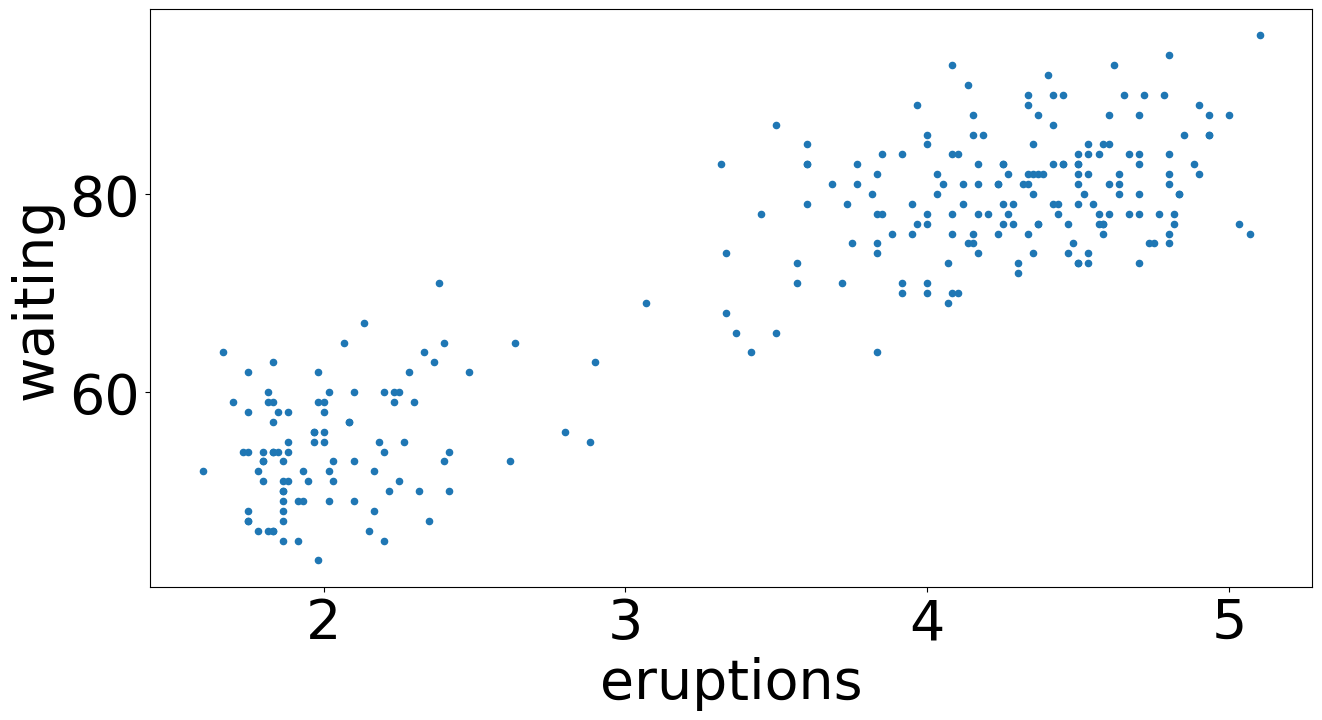

In [4]:
####################
####################
#  data wrangling  #
####################
####################
of_dat=pd.read_table('https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv')
dat=np.array(of_dat)
of_dat.plot.scatter('eruptions','waiting')

In [15]:
########################
########################
#    Mad Mix approx    #
########################
########################

# flow settings
sample_size=2
steps=100
L=15
epsilon=0.001
xi=np.pi/16

# initial arrays
N,D=dat.shape
K=2
mu0=np.array([[2,50],[5,80]])
sigma0=np.zeros((K,D,D))
invsigma0=np.zeros((K,D,D))
for k in range(K): 
    sigma0[k,:,:]=np.array([1.,10.])*np.eye(D)
    invsigma0[k,:,:]=np.eye(D)/np.array([1.,0.1])
# end for
nu0=1.
w0=np.ones(K)/K

# reference sampler
def randq0(size):
    # discrete vars
    rxd  = np.random.randint(low=0,high=K,size=(N,size))
    rud  = np.random.rand(N,size)
    
    # continuous vars
    Kp=K+K*D+int(K*D*(1+0.5*(D-1)))
    rrho = np.random.laplace(size=(Kp,size))
    ruc  = np.random.rand(size)
    
    # weights, means, and covs separately
    rws=np.random.dirichlet(alpha=np.ones(K),size=size).T
    rmus=mu0[:,:,None]+np.sum(np.random.randn(K,D,1,size)*invsigma0[:,:,:,None],axis=2)
    rSigmas=np.zeros((K,D,D,size))
    for k in range(K): rSigmas[k,:,:,:]=np.moveaxis(stats.invwishart(N,N*sigma0[k,:,:]).rvs(size=size),0,2)
    rHs=SigmatoH(rSigmas)
    rxc=madmix_gmm_flatten(rws,rmus,rHs)
    return rxd,rud,rxc,rrho,ruc

y = np.array(of_dat)
lp = gen_lp(K,D)
gen_grad_lp=gen_gen_grad_lp(K)

In [16]:
xd_,ud_,xc_,rho_,uc_=madmix.randqN(sample_size,steps,randq0,L,epsilon,lp,gen_grad_lp,xi)

In [17]:
ws_,mus_,Hs_=madmix_gmm_unflatten(xc_,K,D)
Sigmas_=HtoSigma(Hs_)

Text(0, 0.5, 'Wait time')

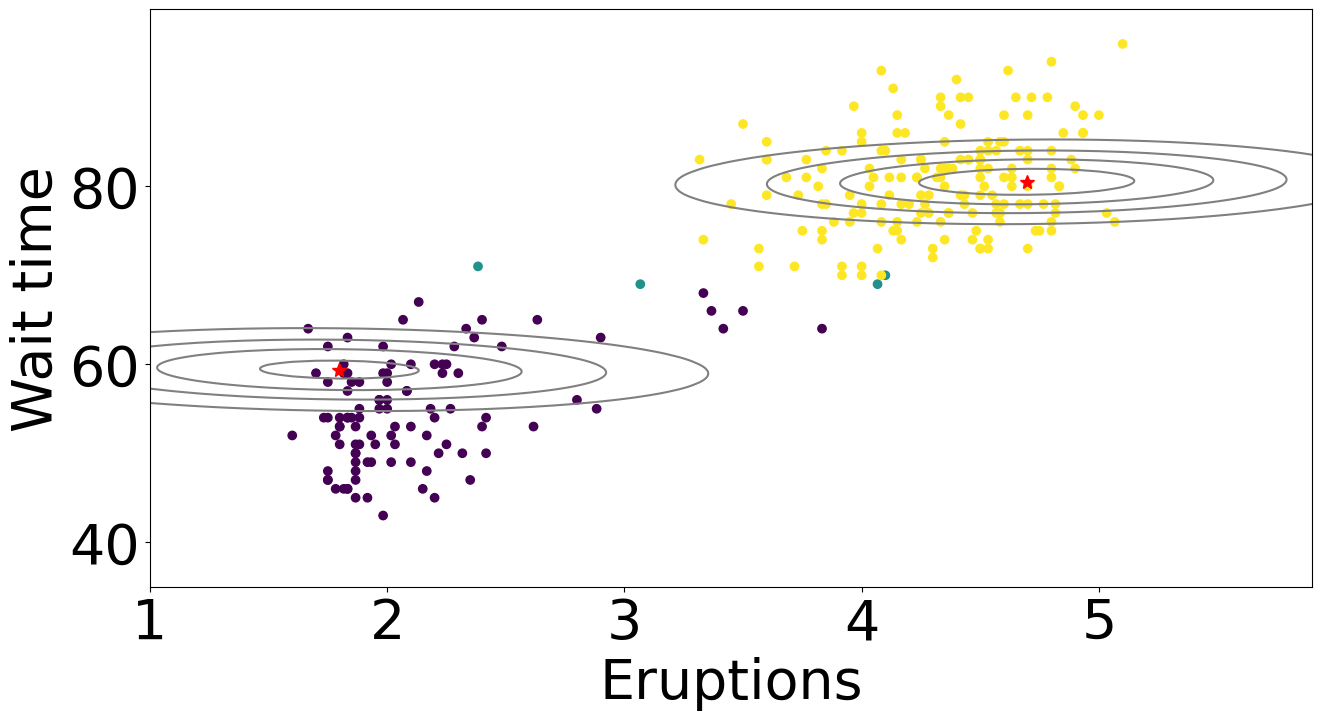

In [19]:
####################
####################
#     results      #
####################
####################
plt.scatter(dat[:,0],dat[:,1],c=np.mean(xd_,axis=-1))
plt.plot(np.mean(mus_,axis=-1)[:,0],np.mean(mus_,axis=-1)[:,1],'*r',ms=10)

xx, yy = np.mgrid[1:6:.1, 35:100:.1]
data = np.dstack((xx, yy))
for k in range(K):
    rv = stats.multivariate_normal(np.mean(mus_,axis=-1)[k,:], np.mean(Sigmas_,axis=-1)[k,:,:])
    zz = rv.pdf(data)
    plt.contour(xx, yy, zz,levels=4,colors='grey')
    
plt.xlabel('Eruptions')
plt.ylabel('Wait time')

## Palmer penguin data set

In [ ]:
from palmerpenguins import load_penguins
penguins = load_penguins().dropna()
std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
pg_dat=np.array(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']])

In [ ]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[colors=='Adelie']='#7ad151'
colors[colors=='Gentoo']='#2a788e'
colors[colors=='Chinstrap']='#440154'
pd.plotting.scatter_matrix(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [ ]:
########################
########################
#    Mad Mix approx    #
########################
########################

# flow settings
sample_size=2
steps=100
L=15
epsilon=0.001
xi=np.pi/16

# initial arrays
N,D=pg_dat.shape
K=3
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,D,D))
invsigma0=np.zeros((K,D,D))
for k in range(K): 
    sigma0[k,:,:]=0.5*np.eye(D)
    invsigma0[k,:,:]=np.eye(D)/0.5
# end for
w0=np.ones(K)/K
nu0=1.

# reference sampler
def randq0(size):
    # discrete vars
    rxd  = np.random.randint(low=0,high=K,size=(N,size))
    rud  = np.random.rand(N,size)
    
    # continuous vars
    Kp=K+K*D+int(K*D*(1+0.5*(D-1)))
    rrho = np.random.laplace(size=(Kp,size))
    ruc  = np.random.rand(size)
    
    # weights, means, and covs separately
    rws=np.random.dirichlet(alpha=np.ones(K),size=size).T
    rmus=mu0[:,:,None]+np.sum(np.random.randn(K,D,1,size)*invsigma0[:,:,:,None],axis=2)
    rSigmas=np.zeros((K,D,D,size))
    for k in range(K): rSigmas[k,:,:,:]=np.moveaxis(stats.invwishart(N,N*sigma0[k,:,:]).rvs(size=size),0,2)
    rHs=SigmatoH(rSigmas)
    rxc=madmix_gmm_flatten(rws,rmus,rHs)
    return rxd,rud,rxc,rrho,ruc

y = np.array(of_dat)
lp = gen_lp(K,D)
gen_grad_lp=gen_gen_grad_lp(K)

In [ ]:
xd_,ud_,xc_,rho_,uc_=madmix.randqN(sample_size,steps,randq0,L,epsilon,lp,gen_grad_lp,xi)